In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
from numpy.polynomial import polynomial
import matplotlib.pyplot as plt
import copy

In [2]:
path_files = '/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/day_1/Z500/'

In [3]:
filenames = np.sort(glob.glob(f'{path_files}b.e21.BHISTsmbb*'))

In [4]:
names_experiments_all = np.array(['.'.join(filenames[i].split('.')[4:-4]) for i in range(len(filenames))])

In [5]:
unique_names_experiments = np.unique(names_experiments_all)

In [6]:
def extractz500_several_files(filestemp):
    listxarrays = []
    for file in filestemp:
        dstemp = xr.open_dataset(file)
        dstemp = dstemp.sel(time=slice('1940-01-01', '2014-12-31'))
        dstemp = dstemp.Z500.where((dstemp.lat>=10),drop=True)
        # Transpose the data to match the desired dimension order
        dstemp_transposed = dstemp.transpose('time', 'lat', 'lon')
        
        # Recreate the DataArray with the coordinates in the desired order
        dstemp_reordered = xr.DataArray(
            dstemp_transposed.values,
            dims=['time', 'lat', 'lon'],
            coords={
                'time': dstemp.coords['time'],
                'lat': dstemp.coords['lat'],
                'lon': dstemp.coords['lon']
            },
            attrs=dstemp.attrs,
            name=dstemp.name
        )
        listxarrays.append(dstemp_reordered)
    xarrayfull = xr.concat(listxarrays, dim='time')
    cftime_index = xr.coding.cftimeindex.CFTimeIndex(xarrayfull['time'].values)
    datetime_index = cftime_index.to_datetimeindex()
    xarrayfull.coords['time'] = datetime_index
    return xarrayfull.to_dataset()
    
def get_weighted_area_average(dataarray):
    # Get latitudes
    lats = dataarray['lat']
    
    # Compute the cosine of the latitudes (in radians) for weighting
    cos_lat_weights = np.cos(np.deg2rad(lats))
    
    # Create a DataArray of the weights along the latitude dimension
    weights = xr.DataArray(cos_lat_weights, dims=['lat'], coords={'lat': lats})
    
    # Apply the weights along the latitude axis and compute the mean across lat/lon
    weighted_mean = (dataarray * weights).mean(dim=['lat', 'lon'])
    
    return weighted_mean
    
def get_trend_of_average_field(dataset, var_name_xarray):
    lat0=20; lat1=80; lon0=180; lon1=330
    dataset = dataset.where((dataset.lat>=lat0)&(dataset.lat<=lat1)&\
                       (dataset.lon>=lon0)&(dataset.lon<=lon1),drop=True)
    xarray_temp = dataset[var_name_xarray]
    mean_series = get_weighted_area_average(xarray_temp)
    X = [i for i in range(0, len(mean_series))]
    y = mean_series.values
    model = LinearRegression()
    model.fit(np.array(X).reshape(-1, 1), y)
    trend = model.coef_[0]
    return mean_series, trend
    
def fourierfilter(dataarray,cutoff_period=10):
    # Compute the Fourier transform along the time axis
    fft_data = np.fft.fft(dataarray, axis=0)
    # Get the frequencies corresponding to the FFT components
    freqs = np.fft.fftfreq(dataarray.shape[0], d=1)  # d=1 assumes daily data; adjust if different
    
    # Compute the corresponding periods (in days)
    periods = np.abs(1 / freqs)
    
    # Define the cutoff period for high-pass filter (10 days)
    cutoff_period = 10
    
    # Create a mask to filter out low-frequency components (longer than 10 days)
    high_pass_mask = periods < cutoff_period
    
    # Apply the mask to the FFT data (set low-frequency components to zero)
    fft_data_filtered = fft_data.copy()
    fft_data_filtered[high_pass_mask, :, :] = 0
    
    # Perform the inverse FFT to get the filtered data back in the time domain
    filtered_data = np.fft.ifft(fft_data_filtered, axis=0).real
    
    # Create a new xarray DataArray to store the filtered data
    filtered_anomalies = xr.DataArray(
        filtered_data,
        dims=dataarray.dims,
        coords=dataarray.coords,
        attrs=dataarray.attrs
    )
    return filtered_anomalies

def compute_anoms_experiment_complete(name_reanalysis):
    name_experiment = unique_names_experiments[id_experiment]
    print(f'Started {name_experiment}')
    where_files = np.where(names_experiments_all==name_experiment)[0]
    files_temp = filenames[where_files]
    dataset_temp = extractz500_several_files(files_temp)
    
    climatology_temp, climatology_std_temp = compute_climatology(dataset_temp)
    
    anoms = (dataset_temp.Z500 - climatology_temp.Z_climo)/climatology_std_temp.Z_climo
    del(climatology_temp)
    del(climatology_std_temp)
    filtered_anoms = fourierfilter(anoms)
    
    filtered_anoms = filtered_anoms.to_dataset(name='Z_anoms')
    filtered_anoms.to_netcdf(f'{path_outputs_anoms}anoms_{name_experiment}.nc')
    print(f'Experiment {name_experiment} complete')

def get_climatology_std_smoothed(dataset, var_name_xarray, window=60):
    # Remove leap day (Feb 29)
    dataset_clima = dataset.isel(time = ~((pd.to_datetime(dataset.time).day == 29) & 
                                          (pd.to_datetime(dataset.time).month == 2)))
    
    # Get the day of year (DOY)
    doy = pd.to_datetime(dataset_clima.time).day_of_year
    climatology = []

    # Compute the daily standard deviation for each day of the year
    for i in range(1, 366):
        array_temp = dataset_clima.isel(time=doy == i)[var_name_xarray]
        std = np.nanstd(array_temp, axis=0)
        std[std == 0] = np.nan
        climatology.append(std)
    
    # Convert to xarray Dataset with the appropriate dimensions
    attrs = dataset[var_name_xarray].attrs
    attrs['File Author'] = 'Jhayron S. Pérez-Carrasquilla'
    
    climatology = xr.Dataset({
        f'{var_name_xarray}_climatology_std': (['day_of_year', 'lat', 'lon'], np.array(climatology)),
    }, 
    coords={
        'day_of_year': np.arange(1, 366),
        'lat': dataset.lat.values,
        'lon': dataset.lon.values,
    },
    attrs=attrs)

    climatology = climatology.transpose('day_of_year', 'lat', 'lon')
    # print(climatology)
    # Stack climatology 3 times to handle edges
    climatology_extended = xr.concat([climatology, climatology, climatology], dim='day_of_year')

    # Adjust coordinates after stacking to represent a larger time span
    climatology_extended['day_of_year'] = np.arange(1, 365 * 3+1)

    # Apply rolling mean with a 60-day window for smoothing
    climatology_smoothed = climatology_extended.rolling(day_of_year=window, center=True, min_periods=1).mean()

    # Extract the middle portion, corresponding to the original 365 days
    climatology_smoothed = climatology_smoothed.isel(day_of_year=slice(365, 365 + 365))

    # Reset 'day_of_year' coordinate to original range
    climatology_smoothed['day_of_year'] = np.arange(1, 366)

    return climatology_smoothed


def standardize_anomalies(anomalies,var_name_xarray,climatology_std):
    std_anomalies = copy.deepcopy(anomalies)
    for day in range(1,367):
        # print(day) 
        if day == 366:
            std_anomalies[var_name_xarray][{'time':(pd.to_datetime(anomalies.time).day_of_year == day)}] = \
                (anomalies[var_name_xarray].isel(time = (pd.to_datetime(anomalies.time).day_of_year == day)) \
                / climatology_std[f'{var_name_xarray}_climatology_std'].sel(day_of_year = day-1))
        else:
            std_anomalies[var_name_xarray][{'time':(pd.to_datetime(anomalies.time).day_of_year == day)}] = \
                (anomalies[var_name_xarray].isel(time = (pd.to_datetime(anomalies.time).day_of_year == day)) \
                / climatology_std[f'{var_name_xarray}_climatology_std'].sel(day_of_year = day))
    # std_anomalies = std_anomalies.rename({var_name_xarray:f'{var_name_xarray}_anomalies'})
    # std_anomalies.to_netcdf(path_save_anomalies)
    return std_anomalies

In [7]:
def compute_anoms_experiment_complete(id_experiment):
    name_experiment = unique_names_experiments[id_experiment]
    where_files = np.where(names_experiments_all==name_experiment)[0]
    files_temp = filenames[where_files]
    dataset_raw = extractz500_several_files(files_temp)
    
    lat0=20; lat1=80; lon0=180; lon1=330
    dataset_region = dataset_raw.where((dataset_raw.lat>=lat0)&(dataset_raw.lat<=lat1)&\
                       (dataset_raw.lon>=lon0)&(dataset_raw.lon<=lon1),drop=True)
    mean_series = get_weighted_area_average(dataset_region)

    ### REMOVE TRENDS AND MEAN
    print(f'Removing trends')
    data = copy.deepcopy(dataset_raw.Z500)
    data_smooth = copy.deepcopy(data).rolling(time=60, center=True,min_periods=1).mean()
    train_data = mean_series.Z500
    npoly=3
    
    # stack lat and lon of ensemble mean data
    if len(train_data.shape) == 3:
        train_data = train_data.stack(z=('lat', 'lon'))
    
    # stack lat and lon of member data & grab doy information
    if len(data.shape) == 3:
        data = data.stack(z=('lat', 'lon'))
        data_smooth = data_smooth.stack(z=('lat', 'lon'))
    temp = data['time.dayofyear']
    
    # grab every Xdoy from ensmean, fit npoly polynomial
    # subtract polynomial from every Xdoy from members
    detrend = []
    for label,ens_group in train_data.groupby('time.dayofyear'):
        Xgroup = data.where(temp == label, drop = True)
        Xgroup_smooth = data_smooth.where(temp == label, drop = True)
        # print(Xgroup.shape)
        curve = polynomial.polyfit(np.arange(0, ens_group.shape[0]), ens_group, npoly)
        trend = polynomial.polyval(np.arange(0, ens_group.shape[0]), curve, tensor=True)
        if len(train_data.shape) == 2: #combined lat and lon, so now 2
            trend = np.swapaxes(trend,0,1) #only need to swap if theres a space dimension
        trend2d = np.tile(trend-np.mean(trend),(Xgroup.shape[1],1)).T
        trend2d_xarr = copy.deepcopy(Xgroup)
        trend2d_xarr.values = trend2d
        
        anoms_temp = Xgroup - np.mean(Xgroup_smooth,axis=0)
        detrended_anoms_temp = anoms_temp - trend2d_xarr
        detrend.append(detrended_anoms_temp)
    detrend_xr = xr.concat(detrend,dim='time').unstack()
    detrend_xr = detrend_xr.sortby('time')

    ## STANDARDIZING
    print(f'Standardizing')
    anoms_region = detrend_xr.where((detrend_xr.lat>=lat0)&(detrend_xr.lat<=lat1)&\
                       (detrend_xr.lon>=lon0)&(detrend_xr.lon<=lon1),drop=True)
    
    clima_std = get_climatology_std_smoothed(anoms_region.to_dataset(),'Z500')
    clima_std_average_region_series = get_weighted_area_average(clima_std)
    clima_std_full_0 = get_climatology_std_smoothed(dataset_raw,'Z500')
    broadcasted_std = clima_std_average_region_series['Z500_climatology_std'].broadcast_like(clima_std_full_0['Z500_climatology_std'])
    
    # Replace the time series in anoms with the broadcasted values
    clima_std_full = copy.deepcopy(clima_std_full_0)
    clima_std_full['Z500_climatology_std'] = broadcasted_std
    std_anomalies = standardize_anomalies(detrend_xr.to_dataset(),'Z500',clima_std_full)
    # LOW-PASS FILTERING
    print(f'Filtering')
    filtered_anoms = fourierfilter(std_anomalies.Z500)
    filtered_anoms = filtered_anoms.to_dataset(name='Z_anoms')
    
    filtered_anoms.to_netcdf(f'{path_outputs_anoms}anoms_{name_experiment}.nc')

In [8]:
path_outputs_anoms = '/glade/derecho/scratch/jhayron/Data4WRsClimateChange/LENS_poly_v3/'

In [9]:
from multiprocessing import Pool

num_ids = len(unique_names_experiments)
num_processors = 5

# Create a Pool of worker processes
with Pool(processes=num_processors) as pool:
    # Map the function to the range of IDs
    pool.map(compute_anoms_experiment_complete, range(num_ids))


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()
/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()
/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This 

Removing trends
Removing trends
Removing trends
Removing trends
Removing trends
Standardizing
Standardizing
Filtering
Standardizing
Filtering
Filtering


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)
/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)
/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


Standardizing
Standardizing
Filtering
Filtering


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)
/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)
/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()


Removing trends


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()


Removing trends


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()


Removing trends


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()
/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()


Removing trends
Removing trends
Standardizing
Standardizing
Filtering
Filtering


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


Standardizing


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


Filtering
Standardizing


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


Filtering


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()
/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


Removing trends
Standardizing


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()


Removing trends
Filtering


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()


Removing trends


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)
/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()


Removing trends


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()


Removing trends
Standardizing
Filtering


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


Standardizing
Standardizing
Filtering
Filtering
Standardizing
Filtering


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)
/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)
/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)
/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()


Removing trends
Standardizing
Filtering


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()


Removing trends


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()


Removing trends


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)
/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()


Removing trends


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()


Removing trends
Standardizing
Filtering


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


Standardizing
Filtering
Standardizing
Standardizing
Filtering
Filtering


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)
/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()
/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)
/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


Removing trends


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()


Standardizing
Removing trends
Filtering


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()
/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()


Removing trends
Removing trends


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)
/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()


Removing trends
Standardizing
Filtering
Standardizing


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


Filtering
Standardizing
Standardizing


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


Filtering
Filtering


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)
/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)
/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()


Removing trends


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()


Removing trends
Standardizing
Filtering


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()
/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()


Removing trends
Removing trends


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)
/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()


Removing trends
Standardizing
Filtering


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


Standardizing
Standardizing
Filtering
Filtering
Standardizing


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


Filtering


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()


Removing trends


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)
/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)
/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()


Removing trends
Standardizing


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()


Removing trends
Filtering


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()


Removing trends


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)
/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()


Removing trends
Standardizing
Filtering
Standardizing
Filtering


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


Standardizing
Standardizing


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


Filtering
Filtering


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)
/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)
/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()


Removing trends


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()


Standardizing
Removing trends
Filtering


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()
/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()


Removing trends
Removing trends


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)
/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()


Removing trends
Standardizing
Standardizing
Filtering
Filtering
Standardizing


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


Standardizing


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


Filtering
Filtering


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)
/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)
/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()


Removing trends


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()


Removing trends


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()
/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()


Standardizing
Removing trends
Removing trends
Filtering


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)
/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()


Removing trends
Standardizing
Filtering
Standardizing
Filtering


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


Standardizing


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


Filtering


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


Standardizing


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()


Removing trends
Filtering


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()


Removing trends


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


Standardizing
Filtering


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


Standardizing
Filtering
Standardizing


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


Filtering


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)
/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()


Removing trends


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()


Removing trends
Standardizing
Filtering


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


Standardizing
Filtering


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)
/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()


Removing trends
Standardizing
Filtering


/glade/derecho/scratch/jhayron/tmp/ipykernel_172503/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


/glade/derecho/scratch/jhayron/tmp/ipykernel_16182/2835793935.py:25: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()


Removing trends


Standardizing
Filtering


/glade/derecho/scratch/jhayron/tmp/ipykernel_16182/2835793935.py:64: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


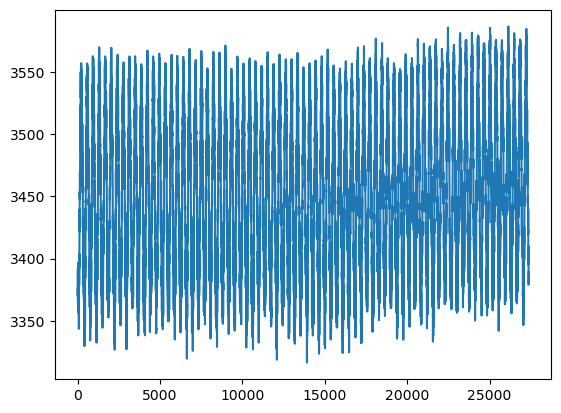

In [13]:
plt.plot(mean_series.Z500)

In [ ]:
def compute_anomalies_full(path_origins, name_reanalysis):
    print(f'*********** {name_reanalysis} **************')
    dataset_raw = xr.open_dataset(f'{path_origins}Z500_{name_reanalysis}.nc')
    lat0=20; lat1=80; lon0=180; lon1=330
    dataset_region = dataset_raw.where((dataset_raw.lat>=lat0)&(dataset_raw.lat<=lat1)&\
                       (dataset_raw.lon>=lon0)&(dataset_raw.lon<=lon1),drop=True)
    mean_series = get_weighted_area_average(dataset_region)

    ### REMOVE TRENDS AND MEAN
    print(f'Removing trends')
    data = copy.deepcopy(dataset_raw.Z)
    data_smooth = copy.deepcopy(data).rolling(time=60, center=True,min_periods=1).mean()
    train_data = mean_series.Z
    npoly=3

    # stack lat and lon of ensemble mean data
    if len(train_data.shape) == 3:
        train_data = train_data.stack(z=('lat', 'lon'))
    
    # stack lat and lon of member data & grab doy information
    if len(data.shape) == 3:
        data = data.stack(z=('lat', 'lon'))
        data_smooth = data_smooth.stack(z=('lat', 'lon'))
    temp = data['time.dayofyear']

    # grab every Xdoy from ensmean, fit npoly polynomial
    # subtract polynomial from every Xdoy from members
    detrend = []
    for label,ens_group in train_data.groupby('time.dayofyear'):
        Xgroup = data.where(temp == label, drop = True)
        Xgroup_smooth = data_smooth.where(temp == label, drop = True)
        # print(Xgroup.shape)
        curve = polynomial.polyfit(np.arange(0, ens_group.shape[0]), ens_group, npoly)
        trend = polynomial.polyval(np.arange(0, ens_group.shape[0]), curve, tensor=True)
        if len(train_data.shape) == 2: #combined lat and lon, so now 2
            trend = np.swapaxes(trend,0,1) #only need to swap if theres a space dimension
        trend2d = np.tile(trend-np.mean(trend),(Xgroup.shape[1],1)).T
        trend2d_xarr = copy.deepcopy(Xgroup)
        trend2d_xarr.values = trend2d
        
        anoms_temp = Xgroup - np.mean(Xgroup_smooth,axis=0)
        detrended_anoms_temp = anoms_temp - trend2d_xarr
        detrend.append(detrended_anoms_temp)
    detrend_xr = xr.concat(detrend,dim='time').unstack()
    detrend_xr = detrend_xr.sortby('time')
    
    ## STANDARDIZING
    print(f'Standardizing')
    anoms_region = detrend_xr.where((detrend_xr.lat>=lat0)&(detrend_xr.lat<=lat1)&\
                       (detrend_xr.lon>=lon0)&(detrend_xr.lon<=lon1),drop=True)
    
    clima_std = get_climatology_std_smoothed(anoms_region.to_dataset(),'Z')
    clima_std_average_region_series = get_weighted_area_average(clima_std)
    clima_std_full_0 = get_climatology_std_smoothed(dataset_raw,'Z')
    broadcasted_std = clima_std_average_region_series['Z_climatology_std'].broadcast_like(clima_std_full_0['Z_climatology_std'])
    
    # Replace the time series in anoms with the broadcasted values
    clima_std_full = copy.deepcopy(clima_std_full_0)
    clima_std_full['Z_climatology_std'] = broadcasted_std
    std_anomalies = standardize_anomalies(detrend_xr.to_dataset(),'Z',clima_std_full)
    # LOW-PASS FILTERING
    print(f'Filtering')
    filtered_anoms = fourierfilter(std_anomalies.Z)
    return detrend_xr.to_dataset(), std_anomalies, filtered_anoms.to_dataset(name='Z_anomalies')

In [8]:
dataset_temp

<xarray.Dataset>
Dimensions:  (time: 27375, lat: 85, lon: 288)
Coordinates:
  * time     (time) datetime64[ns] 1940-01-01 1940-01-02 ... 2014-12-31
  * lat      (lat) float64 10.84 11.78 12.72 13.66 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Data variables:
    Z500     (time, lat, lon) float32 5.841e+03 5.842e+03 ... 5.079e+03

In [8]:
def compute_anoms(dataset):
    dataset=dataset.compute()
    anoms = detrend_obs(dataset.Z500,dataset.Z500)
    std_anoms = standardize_anomalies_with_smoothed_std(anoms)
    filtered_anoms = fourierfilter(std_anoms)
    filtered_anoms = filtered_anoms.to_dataset(name='Z_anoms')
    filtered_anoms = filtered_anoms.drop_vars('dayofyear')
    return filtered_anoms
    # path_output_anoms = f'{path_origins}Z500Anoms_{name_reanalysis}_v2.nc'
    # filtered_anoms.to_netcdf(path_output_anoms)

In [9]:
# anoms_temp = compute_anoms(dataset_temp)

In [10]:
path_outputs_anoms = '/glade/derecho/scratch/jhayron/Data4WRsClimateChange/LENS_poly/'

In [11]:
def compute_anoms_experiment_complete(id_experiment):
    name_experiment = unique_names_experiments[id_experiment]
    print(f'Started {name_experiment}')
    where_files = np.where(names_experiments_all==name_experiment)[0]
    files_temp = filenames[where_files]
    dataset_temp = extractz500_several_files(files_temp)
    anoms_temp = compute_anoms(dataset_temp)
    anoms_temp.to_netcdf(f'{path_outputs_anoms}anoms_{name_experiment}.nc')
    print(f'Experiment {name_experiment} complete')